# Project 1: SIMD Advantage Profiling
## 1. Introduction
The goal of this project is to quantify the real-world performance benefits of SIMD (Single Instruction, Multiple Data) vectorization on common numerical kernels. Modern CPUs provide SIMD units such as SSE, AVX, and AVX-512, which allow multiple data elements to be processed per instruction.

## 2. Methodology
### 2.1 Experimental Environment
CPU: AMD EPYC 9334 32-Core Processor

Compiler: gcc (GCC) 11.5.0 20240719 (Red Hat 11.5.0-5)

OS: Red Hat Enterprise Linux 9.6 (Plow)

Frequency policy: -performance: 3910.2529MHz

SMT:off

ISA support: AVX2

### 2.2 Setup & Measurement Method
Timer: clock_gettime(CLOCK_MONOTONIC) for wall-clock timing.

Repetitions: Each experiment is repeated 10 times

Warm-up: Before official timing, the kernel is run once to reduce cold-start and cold-cache effects.

Data initialization: Random values in the range [-1, 1]

Relative error tolerance: 1e-6

First, compile kernel.c/utils.c

In [ ]:
# 1) saxpy baseline
gcc -O3 -fno-tree-vectorize -DBUILD_LABEL=\"scalar\" utils.c kernel.c -o kernel_scalar

# 2) saxpy SIMD version
gcc -O3 -march=native -DBUILD_LABEL=\"simd\" utils.c kernel.c -o kernel_simd

Then run:

In [ ]:
bash run_sweep.sh
python3 plot_locality.py --csv locality.csv --cpu-hz 3.91e9 --outdir figs
python3 plot_speedup.py  --csv locality.csv --out figs/speedup_all.png

bash run_align.sh
python3 plot_align.py

bash run_stride.sh
python3 plot_stride.py

# 3. Results
## 3.1 Baseline/SIMD version

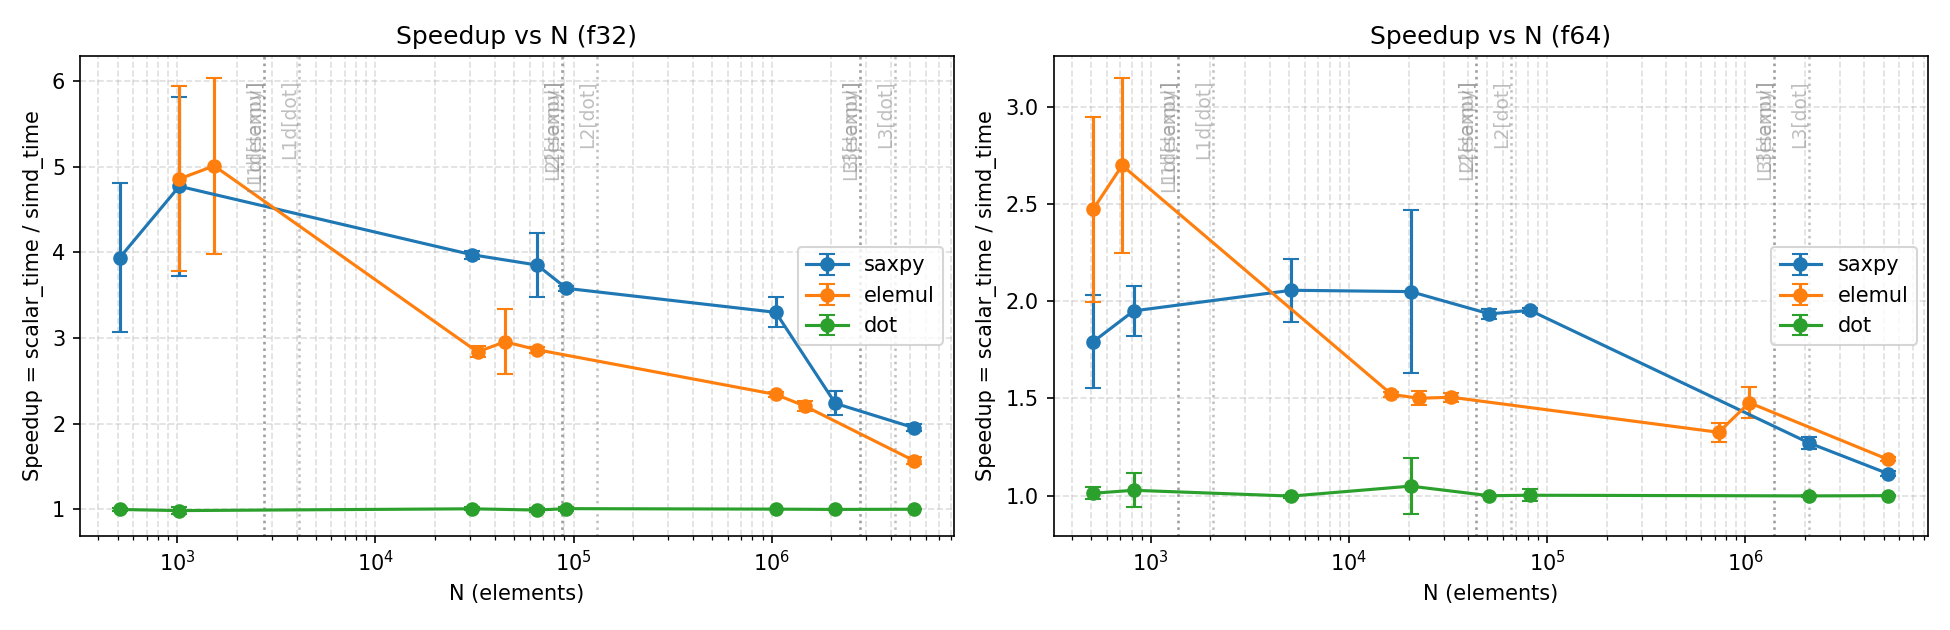

| 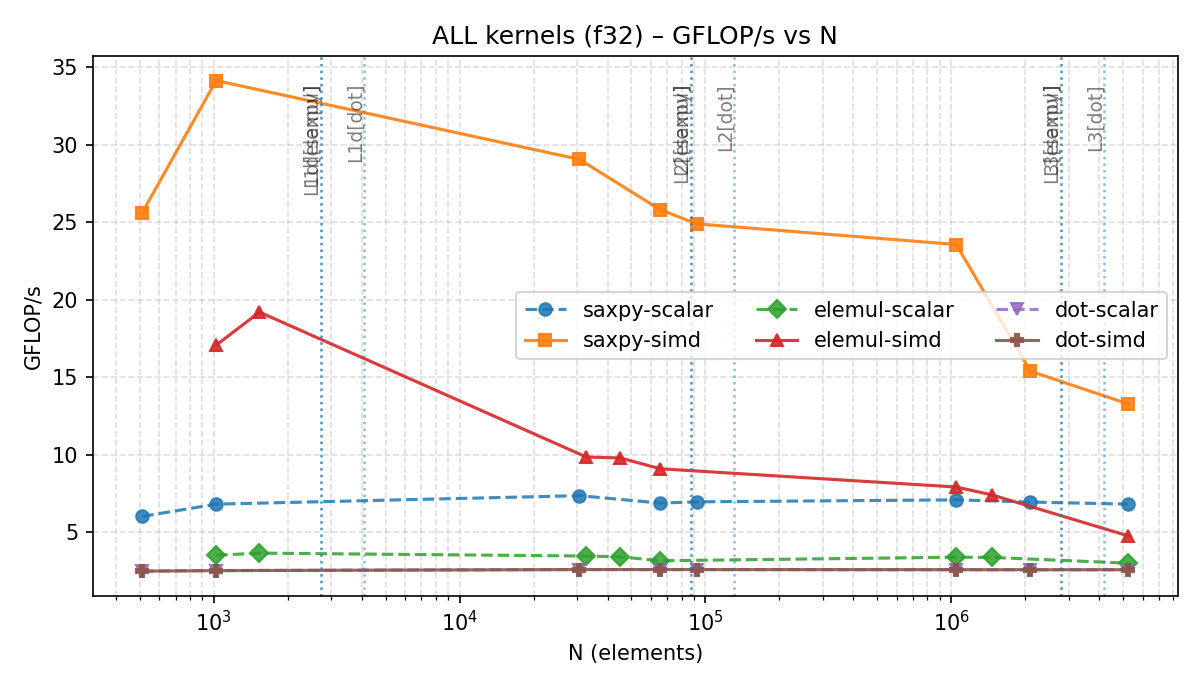 | 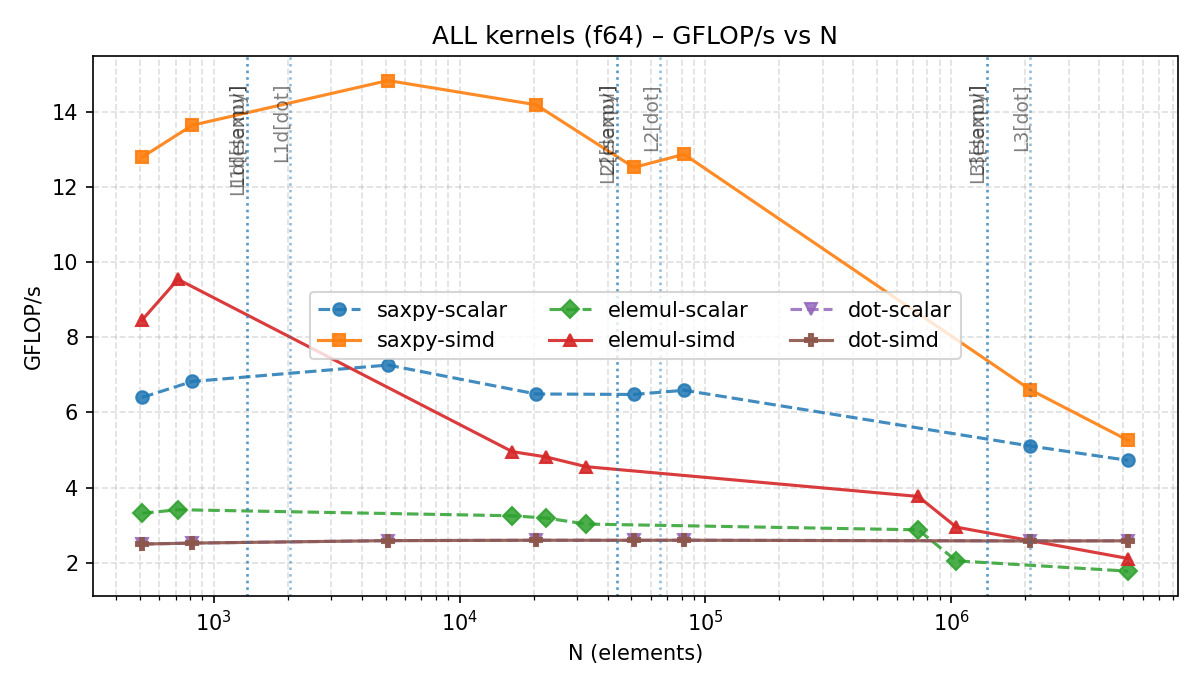|
|:----------------------------------------------------:|:----------------------------------:|

We can see that SIMD acceleration provides significant speedup in compute-bound regions, but the gains diminish as problem size grows and working sets spill beyond cache into DRAM. For SAXPY, which has higher arithmetic intensity thanks to its fused multiply-add pattern, SIMD achieves up to 4–5× speedup in single precision (f32) and about 2× in double precision (f64), with GFLOP/s peaking around the L1/L2 cache range before dropping sharply when memory bandwidth dominates. Elementwise multiply (Elemul) benefits moderately from SIMD, with speedup reaching over 5× in f32 for small N but degrading quickly as sizes cross cache levels, reflecting its lower arithmetic intensity and heavier dependence on memory traffic. In contrast, Dot product shows almost no SIMD advantage across all sizes, staying close to 1× speedup, because the reduction dependency chain prevents full vector parallelism, making its performance largely memory-bound rather than compute-bound. The GFLOP/s shows SIMD SAXPY sustains the highest throughput, SIMD Elemul starts high but collapses as N grows, and Dot remains flat at ~2–3 GFLOP/s with scalar and SIMD nearly identical. 

## 3.2 Vectorization Verification
Generate assembly file:

In [ ]:
# Generate scalar version assembly
gcc -O3 -fno-tree-vectorize -S kernel.c -o kernel_scalar.s

# Generate simd version assembly 
gcc -O3 -march=native -S kernel.c -o kernel_simd.s


In the assembly file kernel_scalar.s (f32/f64), no ymm/zmm registers or vmulps/vfmadd instructions are found.

In kernel_simd.s (f32/f64), we can see vmovups/vfmadd213ps in f32 and vmovupd/vfmadd213pd in f64, which indicates that SIMD was applied with AVX/AVX2 and FMA instructions.

In [ ]:
# kernel_simd.s

saxpy_f32:
.L7:
	vmovups	(%r8,%rax), %ymm1
	vfmadd213ps	(%rsi,%rax), %ymm2, %ymm1
	vmovups	%ymm1, (%rsi,%rax)
	addq	$32, %rax
	cmpq	%rax, %rdx
	jne	.L7
	movq	%rdi, %rax
	andq	$-8, %rax
	testb	$7, %dil
	je	.L28
	movq	%rdi, %rdx
	subq	%rax, %rdx
	leaq	-1(%rdx), %rcx
	cmpq	$2, %rcx
	jbe	.L33
	vzeroupper

saxpy_f64:
.L45:
	incq	%rdx
	vmovsd	(%r8,%rax), %xmm1
	vfmadd213sd	(%rsi,%rax), %xmm0, %xmm1
	vmovsd	%xmm1, (%rsi,%rax)
	addq	%rcx, %rax
	cmpq	%rdx, %rdi
	jne	.L45
	ret
	.p2align 4
	.p2align 3

## 3.3 Locality Sweep
Cache(single thread): L1d = 32KB;  L2 = 1MB;  L3 = 32MB;  Cacheline = 64B

For Saxpy/Dot product:

footprint ≈ 2 × M × sizeof(dtype)

assume we use 50% of cache capacity for data storage, so:

f32(4B):

L1: 0.5 × 32,768 / 8 ≈ 2K

L2：0.5 × 1,048,576/ 8 ≈ 65K

L3: 0.5 × 33,554,432 / 8 ≈ 2.1M

f64 (8B)：

L1: 0.5 × 32,768 / 16 ≈ 1K

L2: 0.5 × 1,048,576 / 16 ≈ 33K

L3: 0.5 × 33,554,432 / 16 ≈ 1.05M

Points we choose: 

f32: [0.5K, 1K, 30K, 64K, 90K, 1M, 2M, 5M]

f64: [0.5K, 0.8K, 5K, 20K, 50K, 80k, 2M, 5M]

For Elementwise multiply:

footprint ≈ 3 × M × sizeof(dtype)

assume we use 50% of cache capacity for data storage, so:

f32(4B):

L1: 0.5 × 32,768 / 12 ≈ 1.4K

L2：0.5 × 1,048,576/ 12 ≈ 44K

L3: 0.5 × 33,554,432 / 12 ≈ 1.4M

f64 (8B)：

L1: 0.5 × 32,768 / 24 ≈ 0.7K

L2: 0.5 × 1,048,576 / 24 ≈ 22K

L3: 0.5 × 33,554,432 / 24 ≈ 0.7M

Points we choose: 

f32: [1K, 1.5K, 32K, 44K, 64K, 1M, 1.4M, 5M]

f64: [0.5K, 0.7K, 16K, 22K, 32K, 0.7M, 1M, 5M]



| 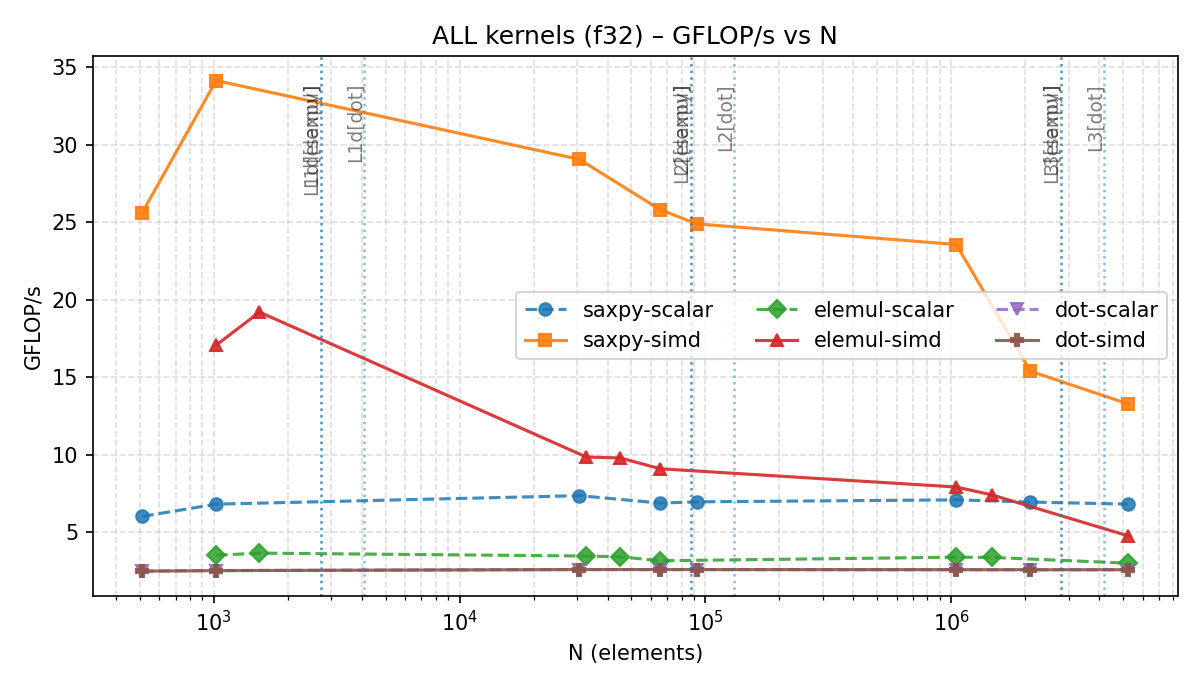 | 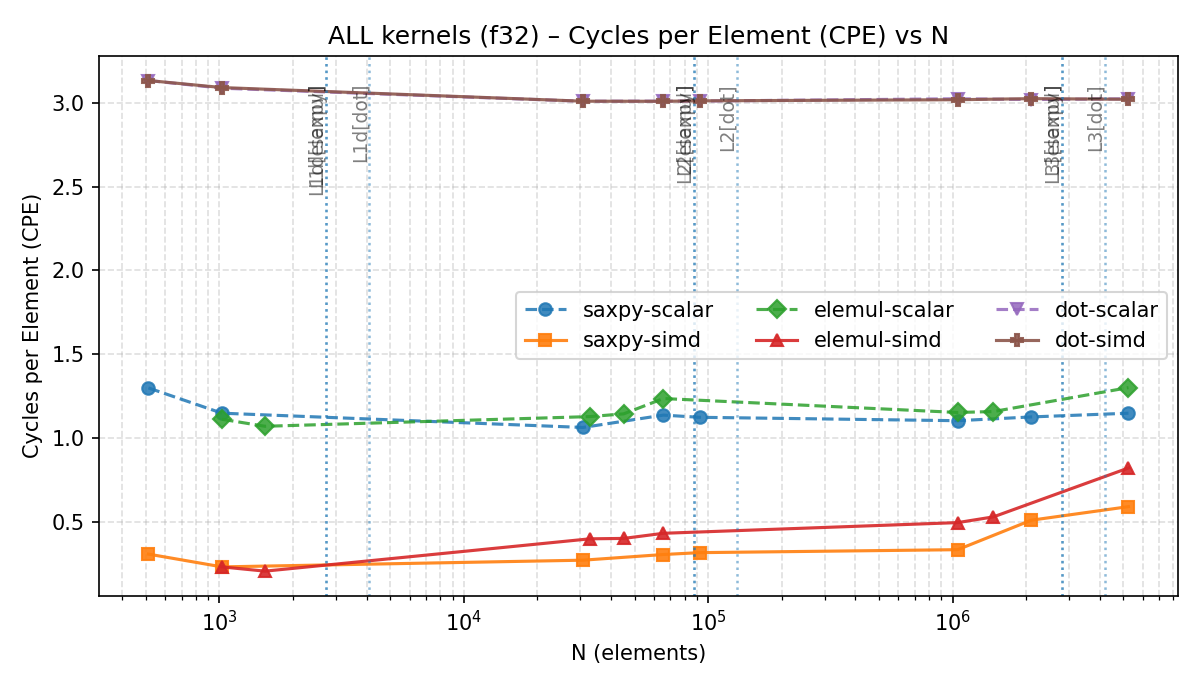 |
|:----------------------------------------------------:|:----------------------------------:|
| All kernel(f32) gflops                                          | All kernel(f32) cpe                                                                   |




For SAXPY and ELEMUL, SIMD achieves a large performance advantage in the cache-bound region: within L1 and L2, SIMD throughput reaches around 30–35 GFLOP/s for SAXPY and 17–19 GFLOP/s for ELEMUL, compared to 6–7 GFLOP/s and 3 GFLOP/s respectively for scalar, corresponding to a speedup of about 5–6× with CPE as low as 0.2–0.4. However, once the working set size exceeds L2 and approaches L3 or DRAM, performance drops significantly: GFLOP/s declines steadily and CPE rises, while the SIMD advantage compresses to only about 1.5–2×. This illustrates that both kernels are memory-bound at large N, with low arithmetic intensity (roughly 0.08–0.16 FLOP/byte) making them sensitive to bandwidth ceilings. In contrast, DOT shows almost no SIMD benefit at any size, sustaining only ~2–3 GFLOP/s with CPE near 3 cycles/element, as the reduction dependency chain and memory accesses dominate execution.

SIMD achieves its best gains while the data fits in L1/L2, but once working sets spill into L3 and DRAM, the bottleneck shifts to memory, and SIMD throughput can no longer scale.

| 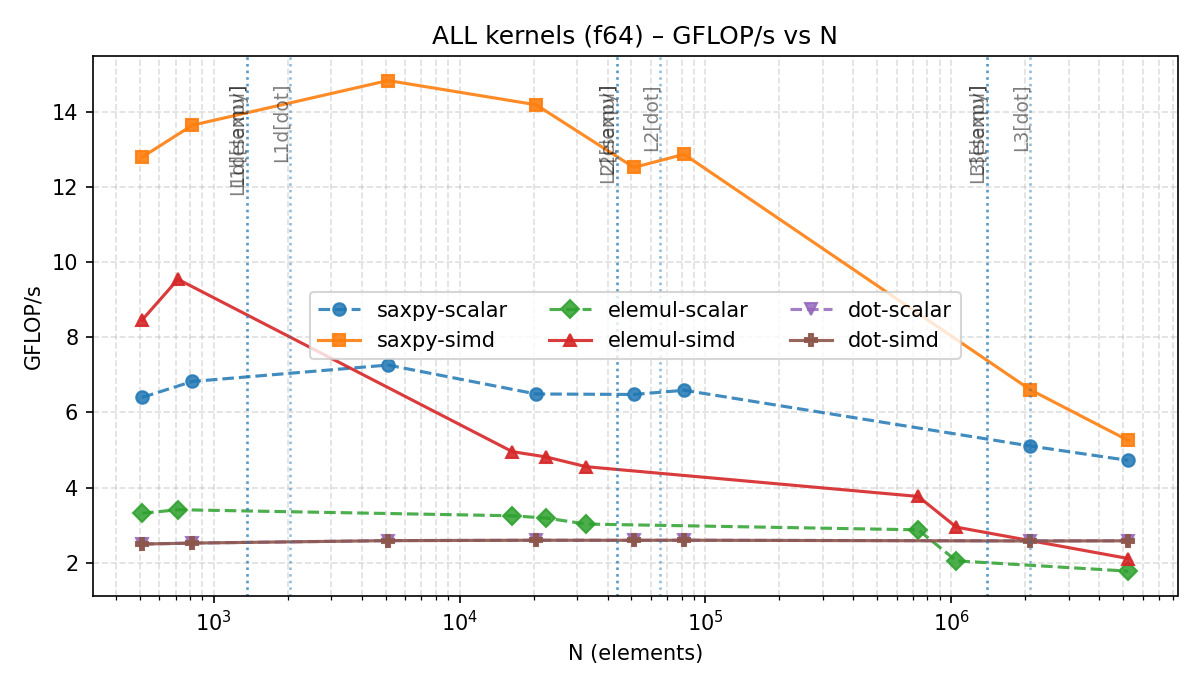 | 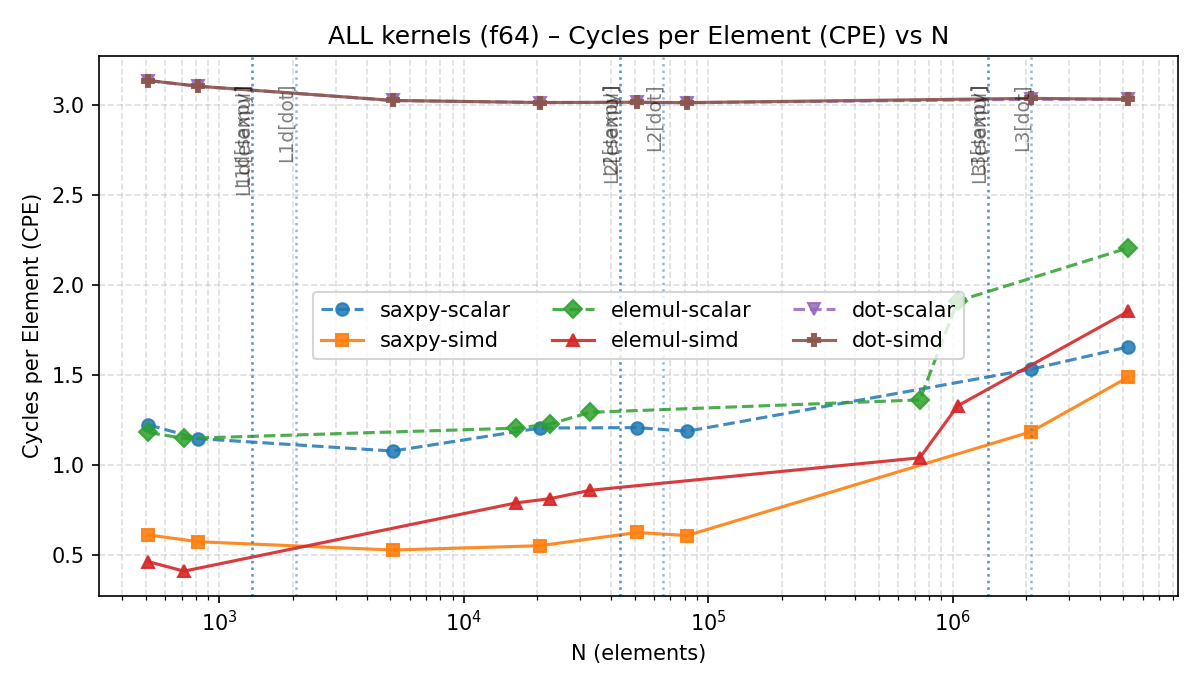|
|:----------------------------------------------------:|:----------------------------------:|
| All kernel(f64) gflops                                          | All kernel(f64) cpe                                                                   |


For the f64 results, the overall trends are similar to what we observed in f32 but with lower absolute performance, since double precision operations demand more bandwidth and execution resources. SAXPY continues to show the strongest SIMD benefits, with SIMD execution reaching peaks above 14 GFLOP/s compared to about 6–7 GFLOP/s for the scalar version, but as the working set size grows and crosses cache boundaries, its performance steadily declines and CPE rises, reflecting the shift from compute-bound to memory-bound behavior. Elemul shows moderate SIMD gains at small sizes, but its performance degrades more quickly than SAXPY as N increases because its arithmetic intensity is even lower, meaning memory traffic dominates earlier. Dot remains essentially unaffected by SIMD: both scalar and SIMD versions sustain only around 2–3 GFLOP/s with a nearly flat CPE curve at ~3 cycles per element,

## 3.4 Alignment & tail handling

| 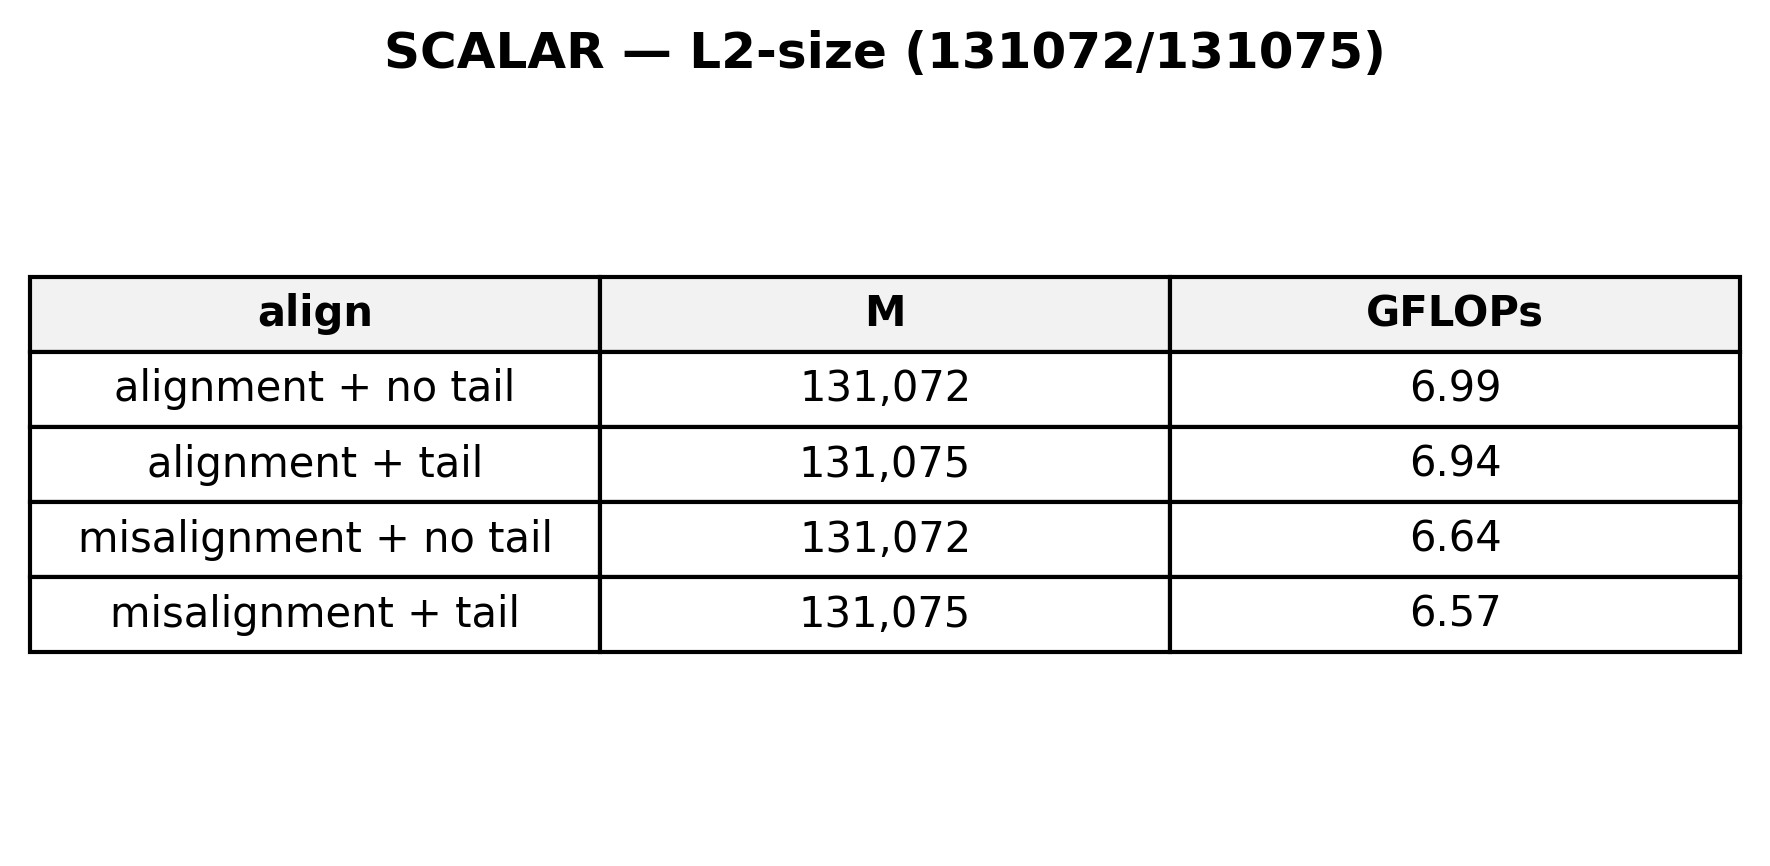| 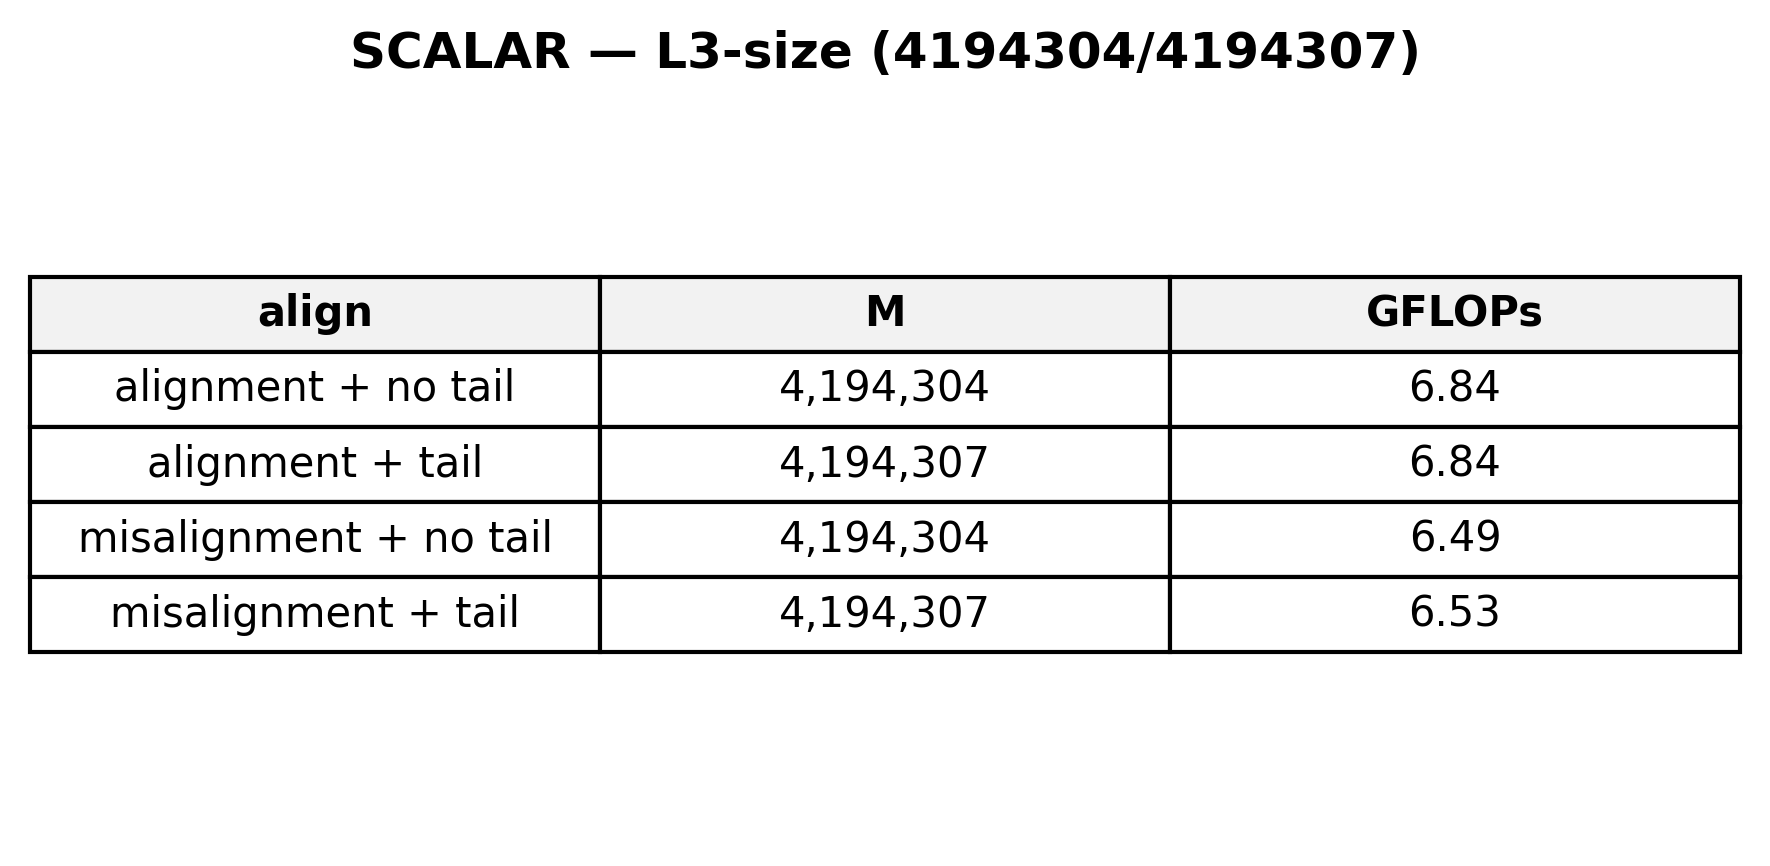|
|:----------------------------------------------------:|:----------------------------------:|

| 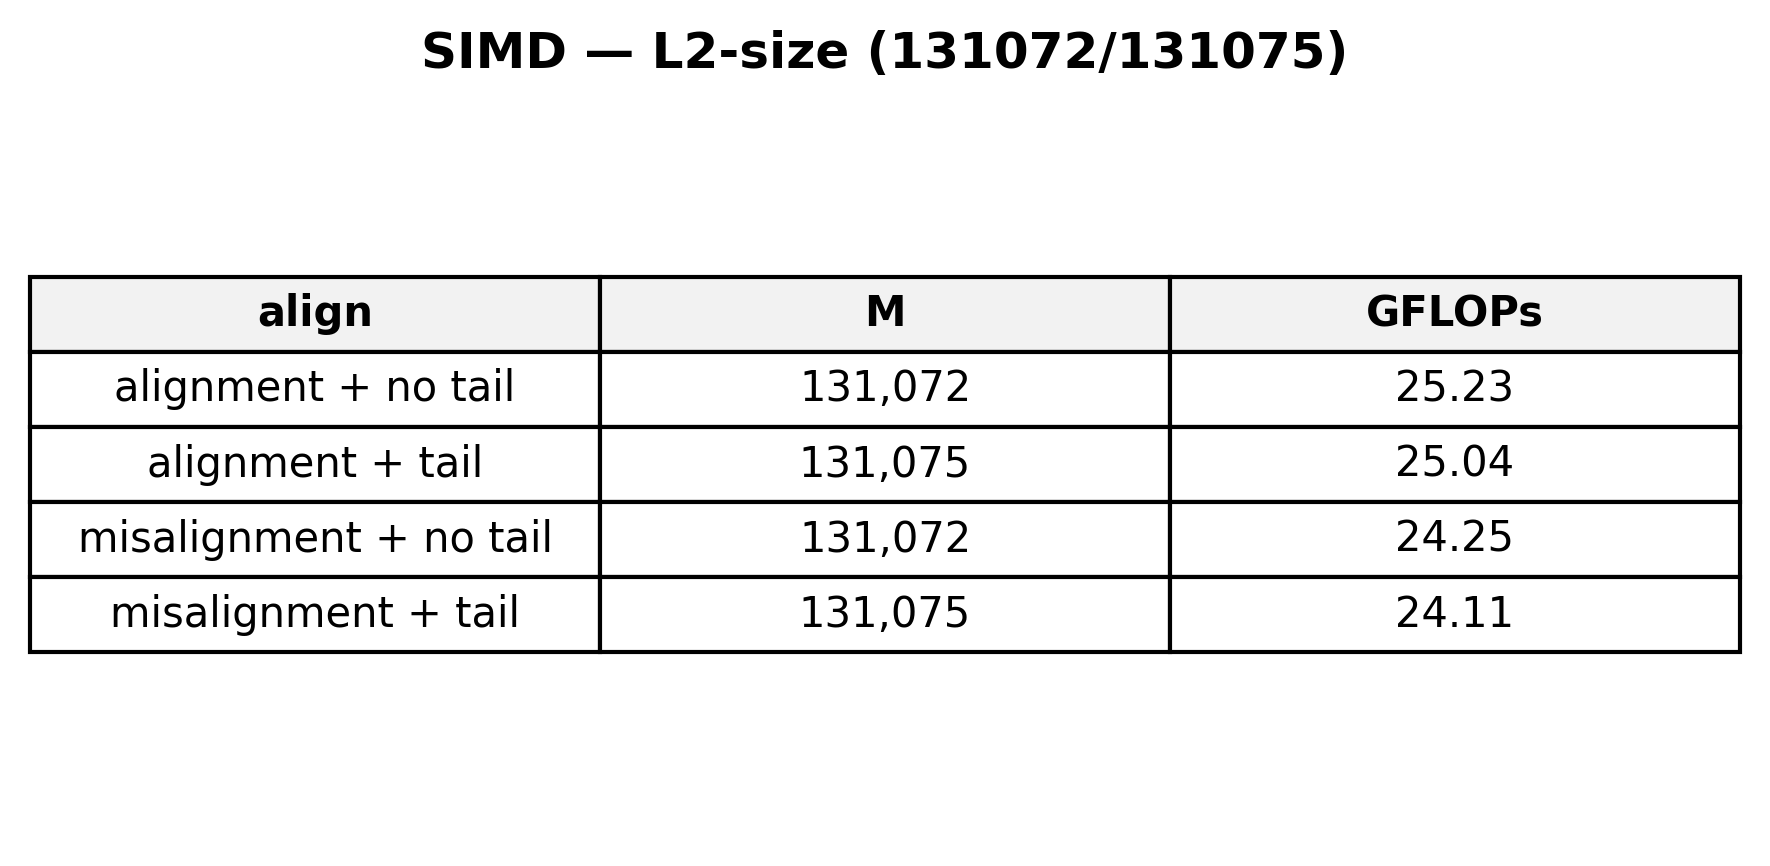| 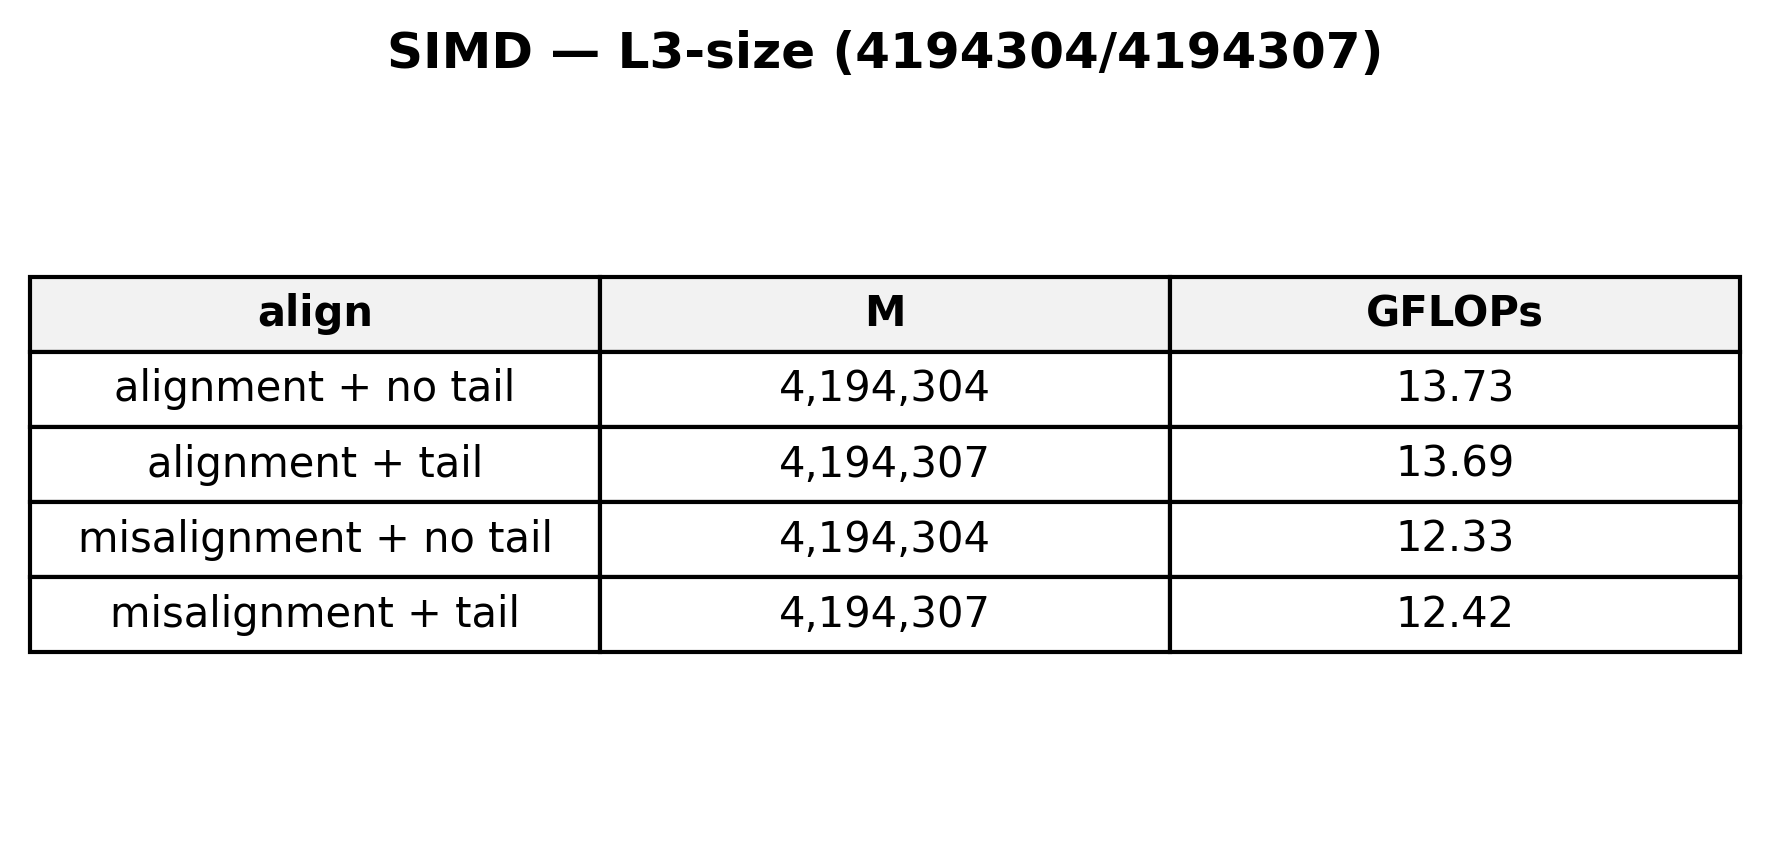|
|:----------------------------------------------------:|:----------------------------------:|

In the scalar implementation, misalignment leads to about a 4–6% performance drop, regardless of whether the data resides in the L2 or L3 cache. This is mainly because unaligned accesses require additional load/store instructions, which increase the number of memory micro-operations and reduce pipeline efficiency. The impact of the tail, however, is smaller.

In the SIMD implementation, alignment has a much greater impact on performance than the tail. Within the L2 cache range, misalignment results in about a 4% performance loss, while the effect of the tail is less than 1%. In the L3 cache range, the cost of misalignment becomes more pronounced, with performance dropping by nearly 10%, whereas the tail has only a minor effect. I believe the reason is that SIMD relies on aligned vector load/store instructions to achieve single-cycle high throughput. When the data is unaligned, the compiler or hardware must resort to unaligned loads or additional split-load instructions. This not only increases the number of memory accesses but may also break cache line alignment, thereby reducing effective bandwidth. For handling non-multiple data lengths, SIMD must process the remaining elements either in the prologue/epilogue stage of the loop or via masking instructions, both of which introduce slight overhead.


## 3.5 Stride effects

| 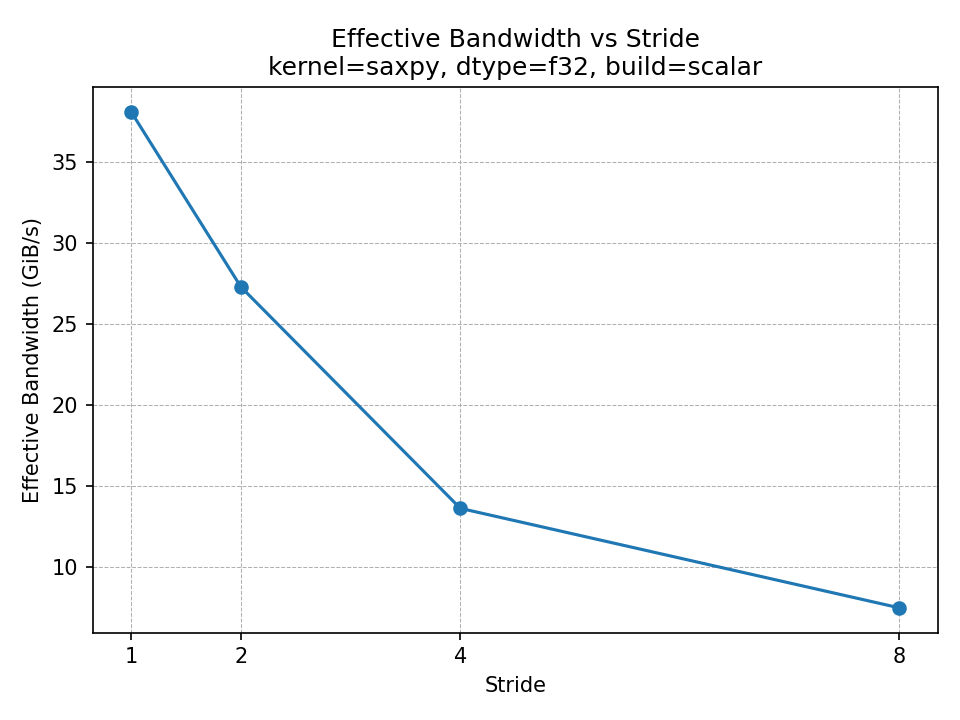| 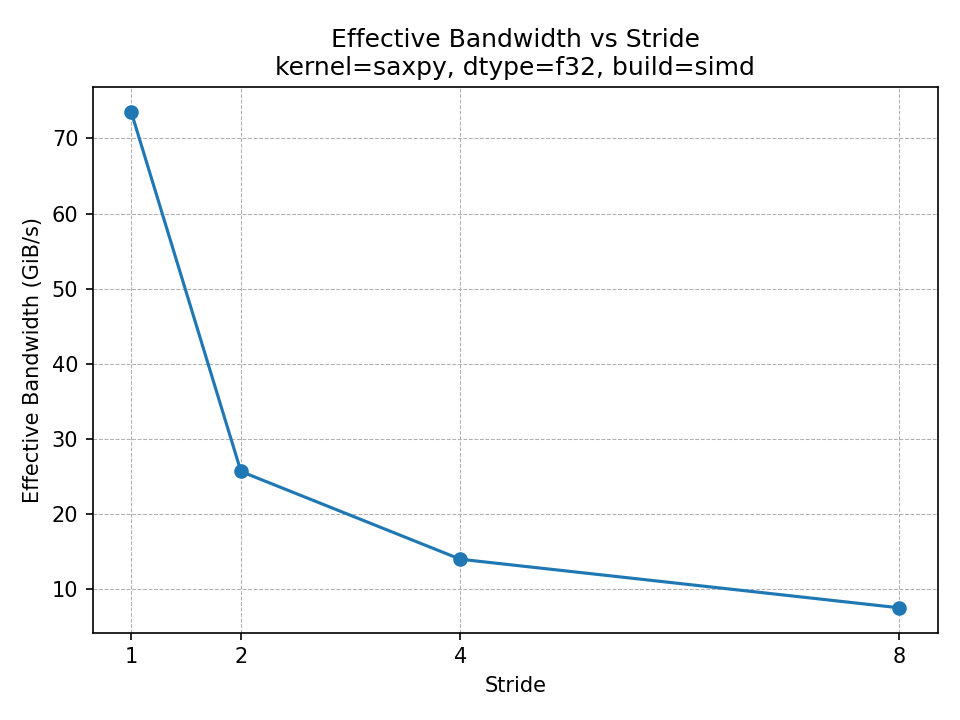|
|:----------------------------------------------------:|:----------------------------------:|

When stride=1, meaning the data are stored consecutively in memory and accessed sequentially, the program can fully leverage the hardware prefetcher and the spatial locality of cache lines, resulting in the highest bandwidth utilization. In this case, the SIMD implementation shows a significant advantage over the scalar implementation—for example, in the SAXPY kernel, the SIMD bandwidth nearly doubles that of the scalar version. However, as the stride value increases, the access pattern gradually shifts to sparse access, where most of the data in each cache line is no longer used, and spatial locality drops sharply. For a 64-byte cache line, the effective utilization is only about 50% when stride=2, drops to 25% at stride=4, and further decreases to around 12.5% at stride=8. This low utilization leads to a rapid decline in memory bandwidth. In such cases, the advantage of SIMD is quickly diminished, and at larger strides its performance approaches that of scalar. SIMD instructions are highly dependent on contiguous and aligned memory access, but under sparse access, the compiler and hardware often need to rely on unaligned loads or split loads to fetch data, which introduces additional memory operations and micro-ops overhead.


## 3.6 Rooffline Analysis for SAXPY

For SAXPY (y = a*x + y):

FLOPs per element: 2 FLOPs (1 multiply + 1 add).

Bytes per element (float32, stride=1): 12B(read: x,y + write: y)

Arithmetic Intensity(f32): 2/12 =0.167 FLOP/Byte

Arithmetic Intensity(f64): 2/12 =0.083 FLOP/Byte

From P2, bandwidth = ≈6.71 GB/s

For AVX2 f32, peak flops ≈ 8x2x2x3.9Ghz = 124.8 GFLOP/s

Ridge point: 124.8 / 6.71 ≈18.60 FLOP/Byte,so for SAXPY(f32) and SAXPY(f64), they are all memory-bound.

The arithmetic intensity of SAXPY is extremely low, and the bandwidth ceiling is far below the CPU peak compute capability. When the data fully resides in cache, SIMD can provide significant acceleration. However, once the data spills into main memory, performance becomes limited by bandwidth, and the SIMD speedup decreases noticeably.
